In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Natural Language Process Project'

/content/drive/My Drive/Natural Language Process Project


# Customer Food Reviews Clustering and Topic Modeling Project

In this project, we use unsupervised learning models to cluster unlabeled fine food reviews into different groups, and identify their latent topics/structures. Finally, we visualize the model results through Principal Component Analysis (PCA).

## Contents

* [Part 1: Load Data](#Part-1:-Load-Data)
* [Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3:-TF-IDF)
* [Part 4: K-means clustering](#Part-4:-K-means-clustering)
* [Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)

# Part 1: Data ETL and Data Exploration
Explored data to obtain general information of dataset and use the first 10000 data as our training data. We then checked the top 5 users who frequently evaluated the food and top 5 popular products for further business analysis.

In [ ]:
import numpy as np
import pandas as pd
import nltk 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
nltk.download('punkt') 
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('Reviews.csv')

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.dropna(subset=['Text'],inplace=True)

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
# use the first 10000 data as our training data

data = df.loc[:9999, 'Text'].tolist()

In [ ]:
data[0:10]

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.',
 'If you are looking f

In [ ]:
# Top 5 users who give rating scores
df.groupby('UserId')['Score'].count().nlargest(5)

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
Name: Score, dtype: int64

In [ ]:
# Top 5 popular products
df.groupby('ProductId')['Score'].sum().nlargest(5)

ProductId
B007JFMH8M    4184
B003B3OOPA    2953
B0026RQTGE    2900
B002QWHJOU    2900
B002QWP89S    2900
Name: Score, dtype: int64

In [ ]:
# Top 5 users who gave only 1 score 
df[df.Score == 1].groupby('UserId')['Score'].count().nlargest(5)

UserId
A3TVZM3ZIXG8YW    199
AKZKG2Z7CNV27      67
AMQ1MEG334SAP      47
AF3BYMPWKWO8F      43
A3IE3TQ79W0YOR     42
Name: Score, dtype: int64

In [ ]:
# Top 5 users who often gave only 5 score 
df[df.Score == 5].groupby('UserId')['Score'].count().nlargest(5)

UserId
A281NPSIMI1C2R    326
AY12DBB0U420B     286
A3OXHLG6DIBRW8    271
A1YUL9PCJR3JTY    240
A1TMAVN4CEM8U8    182
Name: Score, dtype: int64

In [ ]:
# Top 5 products which mostly got only 1 score
df[df.Score == 1].groupby('ProductId')['Score'].count().nlargest(5)

ProductId
B000X1Q1G8    134
B006N3I69A    105
B000CNB4LE    103
B003CIBPN8    103
B004SRFYMK    103
Name: Score, dtype: int64

# Part 2: Tokenizing and Stemming


Import NLTK library to load stopwords and stemmer function.
Tokenization is the process breaking customer reviews data intp simple units called tokens.

Stop words are words like "a", "the", "an", "in" which don't provide any significant information in language processing.

Stemming is the process of reducing derived words down to word root form.

After the processing, we create a wordcloud to visualize the frequently words.


In [ ]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english') #stopwords.append("n't")
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br") #html <br>
stopwords.append("fine food")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [ ]:
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):

    # exclude stop words and tokenize the document, generate a list of string 
    tokens = list(filter(lambda word: word.lower() not in stopwords, nltk.word_tokenize(text)))
    tokens = list(map(lambda token: token.lower(), tokens))

    # for word in nltk.word_tokenize(text):
    #     if word.lower() not in stopwords:
    #         tokens.append(word.lower())

    filtered_tokens = list(filter(lambda token: token.isalpha(), tokens))
    
    # filtered_tokens = []
    
    # # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    # for token in tokens: 
    #     if token.isalpha():
    #         filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [ ]:
tokenization_and_stemming(data[5])

In [ ]:
data[5]

'I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.'

In [ ]:
# Create World Cloud
text_cleaned = []
#Read the tweets one by one and process it
for i in range (0,len(data)):
    processedText = tokenization_and_stemming(data[i])
    text_cleaned.append(processedText)
print(len(text_cleaned))
text_cleaned[0:10]

In [ ]:
# text_cleaned = [i for i in text_cleaned]

from itertools import chain

text_cleaned = list(chain.from_iterable(text_cleaned))
text_cleaned

In [ ]:
from pandas.core.frame import DataFrame
df_text ={"txts": text_cleaned}
data_text = DataFrame(df_text)#transfer into a dataframe
print(data_text.shape)
data_text.head(1000)

(363805, 1)


,txts
0,bought
1,sever
2,vital
3,can
4,dog
...,...
995,get
996,almost
997,half
998,price


(-0.5, 399.5, 199.5, -0.5)

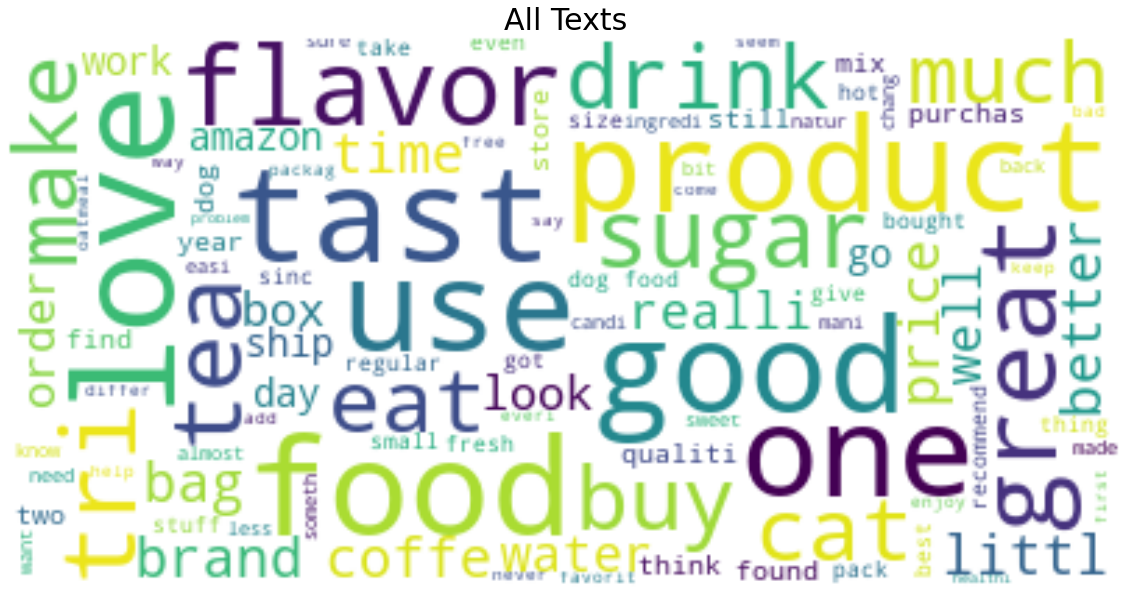

In [ ]:
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
df_text ={"txts": text_cleaned}
data_text = pd.DataFrame(df_text)#transfer into a dataframe
text_All = " ".join(review for review in data_text.txts[:10000])
fig, ax = plt.subplots(1, 1, figsize  = (20,20))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_All)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Texts', fontsize=30)
ax.axis('off')

# Part 3: TF-IDF

TF: Term Frequency
IDF: Inverse Document Frequency
[link text](https://stackoverflow.com/questions/64568775/tf-idf-vectorizer-to-extract-ngrams).
TF-IDF is to reflect the importance of a word to a document in a collection or corpus.
We can use TF-IDF to remove the words that are less important for analysis.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,3)) #ngram_range means use 1-gram

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.") #10000 reviews(行) 600 terms(features)（列）

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.



In total, there are 10000 reviews and 600 terms.


In [ ]:
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.23894133],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.23894133],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Save the terms identified by TF-IDF.

In [ ]:
# words
tf_selected_words = tfidf_model.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
# print out words
print(len(tf_selected_words))
tf_selected_words[:10]

600


['abl',
 'absolut',
 'acid',
 'actual',
 'ad',
 'add',
 'addict',
 'addit',
 'aftertast',
 'ago']

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

# Part 4: K-means clustering
Group similar data points together and discover underlying review patterns. 
We set up 10 clusters.


In [ ]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters = 10

# number of clusters
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
print(clusters)
len(clusters)

[3, 7, 6, 6, 7, 6, 6, 6, 5, 3, 6, 3, 5, 6, 6, 6, 6, 7, 6, 7, 7, 7, 7, 6, 6, 7, 6, 7, 6, 6, 8, 7, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 7, 6, 7, 4, 7, 7, 6, 7, 7, 6, 6, 6, 7, 6, 7, 6, 6, 6, 7, 9, 4, 7, 7, 9, 6, 6, 6, 3, 3, 3, 3, 7, 3, 3, 6, 3, 3, 3, 7, 3, 3, 3, 3, 6, 7, 7, 6, 7, 6, 6, 7, 7, 6, 6, 6, 9, 9, 9, 9, 9, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 4, 6, 7, 6, 4, 7, 6, 7, 6, 6, 6, 7, 6, 6, 7, 6, 6, 6, 7, 6, 3, 6, 6, 7, 6, 7, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 7, 6, 6, 7, 8, 6, 7, 6, 7, 0, 6, 7, 7, 7, 6, 6, 7, 6, 4, 8, 8, 6, 8, 6, 6, 6, 6, 7, 6, 6, 7, 6, 6, 7, 6, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 7, 6, 7, 6, 9, 9, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 9, 9, 6, 6, 6, 6, 3, 3, 9, 4, 9, 9, 9, 9, 9, 9, 7, 7, 7, 6, 7, 7, 3, 6, 8, 6, 6, 7, 6, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 2, 6, 6, 1, 6, 6, 7, 7, 7, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 9, 7, 7, 7, 6, 6, 6, 4, 6, 6, 7, 6, 7, 8, 8, 8, 4, 4, 6, 7, 6, 6, 7, 7, 7, 6, 6, 7, 7, 7, 8, 7, 7, 

10000

## 4.1. Analyze K-means Result
Each clusters have different number of observations. The imbalanced data allocation will cause the inaccurate result.

In [ ]:
# create DataFrame films from all of the input files.
product = { 'text': df[:10000].Text, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['text', 'cluster'])

In [ ]:
frame.head(60)

In [ ]:
print ("Number of texts included in each cluster:")
frame['cluster'].value_counts().to_frame() 


Number of texts included in each cluster:


,cluster
7,4108
4,1633
1,1375
9,533
2,485
0,443
8,432
5,401
3,357
6,233


In [ ]:
km.cluster_centers_ 

array([[0.0061992 , 0.00908183, 0.0003468 , ..., 0.00200287, 0.00166492,
        0.00544978],
       [0.00383058, 0.00538488, 0.0107842 , ..., 0.        , 0.00120883,
        0.00354932],
       [0.00494719, 0.00871692, 0.00120118, ..., 0.00169355, 0.00149102,
        0.00120982],
       ...,
       [0.00465426, 0.00591397, 0.00373194, ..., 0.00469075, 0.00325027,
        0.00475654],
       [0.00376862, 0.00707114, 0.00054616, ..., 0.01749554, 0.00207985,
        0.00056393],
       [0.00571969, 0.00744783, 0.00108516, ..., 0.00121917, 0.00207208,
        0.00454801]])

In [ ]:
km.cluster_centers_.shape

(10, 600)

In [ ]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}

for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].text.tolist()
    print ("Cluster " + str(i) + " texts (" + str(len(cluster_reviews)) + " texts): ")
    print (", ".join(cluster_reviews[:10]))
    print ()

<Document clustering result by K-means>
Cluster 0 words:chocol,hot,cocoa,hot chocol,hot cocoa,tast,
Cluster 0 texts (443 texts): 
These looked like a perfect snack to through in with my trail mix.  Unfortunately, they arrived in a solid mass of melted chocolate.  I left them in my pantry for a few days, and when I opened them at room temperature they were still gooey.  I through them in the fridge and I've been breaking off hunks ever since.  They taste good to me, but the chocolate is all grainy after melting and then solidifying again.  I won't order them online again, but if I see them in a store I would pick them up., I've been eating Ramen noodles since I was a little kid, and I've never found a better flavor than Hot & Spicy Chicken!  It isn't hot at all to a chilihead like me, but it sure is good!, I really loved the spicy flavor these had.  I found myself liking the broth more than the noodles which is usually the opposite.  If you aren't used to the heat this might bother you 

## 4.2. Principal Component Analysis
Visualizing Document Clustering.
According to the data visualization, several clusters are overlapped and there is no clear boundry between each clusters.




In [ ]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
from sklearn.decomposition import PCA


PCA()

# convert two components as we're plotting points in a two-dimensional plane
# we will also specify `random_state` so the plot is reproducible.
pca = PCA(n_components=2, random_state=1)

pos = pca.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 
                  5: '#5e1ea6', 6: '#a61e66', 7: '#1e66a6', 8: '#7f7f7f', 9: '#8c564b'}

#set up cluster names using a dict
cluster_names = {0: 'chocol, hot, cocoa', 
                 1: 'coffee, flavor, roast', 
                 2: 'tea, green, drink', 
                 3: 'juic, orang, soda', 
                 4: 'product, order, price',
                 5: 'pancake, gluten free, waffl',
                 6:'cat, food, treat',
                 7:'tast, good, great',
                 8:'dog, food, love',
                 9:'chip, flavor, potato'}

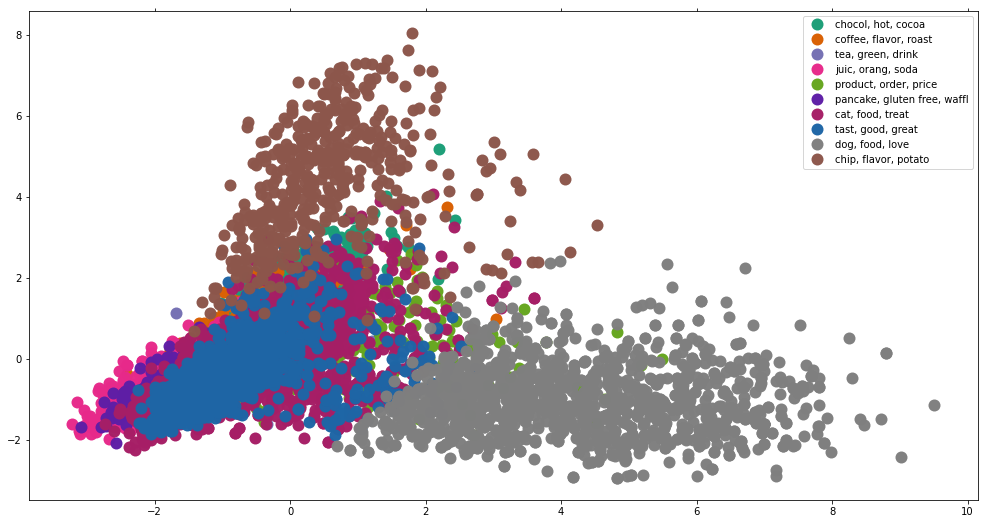

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the PCA plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none', alpha = 5)
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

# Part 5: Topic Modeling - Latent Dirichlet Allocation
The aim of LDA is to find topics a document belongs to, based on the words in it. [link text](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)

Applying LDA to a set of reviews, we would end up with a probability distribution of topics for each reviews.

In [ ]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10) # n_components: divided into several topics

In [ ]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output.shape)
print(lda_output)
# documents and topics
# each rows represent a review, each columns represent the probability of each topics
# the total probability of each row is equal to 1

(10000, 10)
[[0.02135884 0.02135772 0.02135769 ... 0.02135727 0.02135893 0.02135714]
 [0.02632769 0.51578092 0.02632384 ... 0.0263283  0.02633072 0.02632657]
 [0.02120305 0.02120247 0.0211985  ... 0.02120362 0.02119945 0.68136153]
 ...
 [0.01782677 0.01782512 0.01782325 ... 0.01783374 0.01782711 0.01782588]
 [0.03137744 0.0313766  0.03137839 ... 0.03137626 0.03137555 0.03137538]
 [0.01417174 0.0141713  0.01417053 ... 0.01417422 0.01417086 0.01417112]]


##5.1. Analyze LDA Result




In [ ]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(10, 600)
[[15.46663755  7.80307836  0.19809557 ...  0.10004802  3.99475051
   5.58752395]
 [ 5.03741618  7.72365325  0.53364904 ...  0.1056357   2.81284884
   3.40776955]
 [ 5.08124837  8.47738853 22.68366918 ...  0.10000001  3.19050555
   3.18190533]
 ...
 [ 1.44809179  1.51918446  5.31610156 ...  0.39546552  3.87745943
   1.55427671]
 [ 1.91537177  2.26924281  0.10015688 ...  0.1000088   0.10007193
   2.88010538]
 [ 5.15122737  6.18017372  1.73194482 ...  0.5663392   1.01230114
   3.48716047]]


In [ ]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,topic
Doc0,0.02,0.02,0.02,0.02,0.02,0.81,0.02,0.02,0.02,0.02,5
Doc1,0.03,0.52,0.03,0.27,0.03,0.03,0.03,0.03,0.03,0.03,1
Doc2,0.02,0.02,0.02,0.02,0.02,0.15,0.02,0.02,0.02,0.68,9
Doc3,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.77,0.03,0.03,7
Doc4,0.75,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0
Doc5,0.02,0.02,0.02,0.02,0.02,0.30,0.02,0.02,0.54,0.02,8
Doc6,0.02,0.02,0.02,0.02,0.79,0.02,0.02,0.02,0.02,0.02,4
Doc7,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.76,0.03,8
Doc8,0.03,0.03,0.03,0.03,0.03,0.69,0.03,0.03,0.03,0.03,5
Doc9,0.02,0.02,0.02,0.02,0.02,0.78,0.02,0.02,0.02,0.02,5


In [ ]:
df_document_topic['topic'].value_counts().to_frame()

,topic
2,1614
4,1560
0,1237
1,1135
3,941
5,885
9,862
7,619
6,596
8,551


In [ ]:
# topic word matrix
print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model.get_feature_names()
df_topic_words.index = topic_names

df_topic_words.head()

[[15.46663755  7.80307836  0.19809557 ...  0.10004802  3.99475051
   5.58752395]
 [ 5.03741618  7.72365325  0.53364904 ...  0.1056357   2.81284884
   3.40776955]
 [ 5.08124837  8.47738853 22.68366918 ...  0.10000001  3.19050555
   3.18190533]
 ...
 [ 1.44809179  1.51918446  5.31610156 ...  0.39546552  3.87745943
   1.55427671]
 [ 1.91537177  2.26924281  0.10015688 ...  0.1000088   0.10007193
   2.88010538]
 [ 5.15122737  6.18017372  1.73194482 ...  0.5663392   1.01230114
   3.48716047]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,abl,absolut,acid,actual,ad,add,addict,addit,aftertast,ago,agre,allergi,allow,alreadi,altern,alway,amaz,amazon,anoth,anyon,anyth,appl,area,aroma,arriv,artifici,ask,ate,avail,away,awesom,babi,bad,bag,bake,balanc,bar,base,basic,batch,...,unlik,use,usual,valu,vanilla,varieti,varieti pack,veget,version,vinegar,vitamin,waffl,wait,want,wast,water,way,weak,websit,week,weight,went,wheat,white,wife,wish,wo,wolfgang,wolfgang puck,wonder,work,world,worri,worth,wrong,year,year ago,year old,yes,yummi
Topic0,15.466638,7.803078,0.198096,4.895098,7.170611,13.481478,0.565999,5.255518,0.100009,7.932541,2.753375,2.575032,2.069498,1.326908,3.520499,17.398401,5.050068,64.146456,5.556605,6.427838,7.400872,3.248137,14.094067,0.100049,8.839466,0.100009,4.014291,1.836869,17.481464,2.677828,6.730914,0.100043,4.531336,6.436881,36.327514,1.562910,5.067768,1.845548,3.053849,3.730777,...,3.401644,53.168016,9.203867,3.745539,3.602941,2.218942,0.100000,2.025385,5.727133,0.100044,0.115378,42.762904,6.157526,8.013088,2.413147,5.735494,16.041979,0.100001,2.832683,4.951573,0.100002,10.321333,10.995903,6.027132,2.037613,14.763127,4.992340,0.100001,0.100001,15.430709,13.077279,3.214537,0.705943,12.998002,1.184003,21.661566,6.518695,0.100048,3.994751,5.587524
Topic1,5.037416,7.723653,0.533649,7.921201,1.631061,2.685551,17.885118,3.686208,2.822960,2.162973,4.635357,0.530769,4.078475,3.214355,12.683687,7.775823,3.969335,29.871598,7.620611,4.968346,4.608432,0.100004,0.989731,1.526128,13.461479,2.904121,4.179748,4.094075,5.461077,10.481498,9.546631,1.238153,14.762912,86.174992,11.392208,3.390891,0.100025,2.580986,1.026081,2.076999,...,2.115974,12.376431,5.195760,4.887959,0.100001,20.710840,15.042637,0.623388,4.313002,36.526917,1.234198,0.100000,2.783750,20.073941,6.367537,2.562979,14.863412,0.100086,4.071926,7.210366,13.417884,4.009134,0.100020,1.690164,1.713259,10.365974,10.855978,0.100001,0.100002,9.880817,7.391864,2.190966,1.848769,8.818540,7.043354,5.048557,0.338379,0.105636,2.812849,3.407770
Topic2,5.081248,8.477389,22.683669,7.713591,5.136607,6.929734,2.285913,1.369615,17.499492,2.063063,2.618662,0.100000,5.618914,7.668241,6.491500,15.776799,6.433644,21.039203,14.315606,3.404892,6.718567,0.100000,2.208233,28.633090,4.486200,1.991697,4.800331,0.100000,12.332559,7.383389,8.051039,0.100000,16.736992,9.496529,0.100016,8.962981,0.100000,3.447825,2.260425,4.907400,...,2.049466,48.236078,15.438307,4.299712,27.548928,12.054973,2.780474,0.100000,3.709528,0.100006,0.100003,0.100000,7.430199,22.821754,8.782854,15.609377,20.714205,35.103048,0.564021,6.536269,0.100001,2.459475,0.100000,0.100000,10.278169,8.286764,7.985152,53.781427,45.408436,16.208353,22.718024,4.851142,0.828899,13.623395,4.909095,9.058689,0.228549,0.100000,3.190506,3.181905
Topic3,1.345450,7.971955,0.100275,7.859935,12.876354,19.793905,6.720021,3.947438,0.252497,5.544427,3.859454,5.101602,2.226465,3.292988,4.362438,13.349937,6.205040,11.173793,2.970612,2.692189,10.718020,2.716801,0.285621,0.100481,1.795002,0.100142,1.440209,4.015917,4.732078,2.450563,1.004915,15.557168,4.917564,4.104910,6.449885,0.387720,34.475854,2.487672,1.798912,0.817694,...,2.148083,19.906437,7.425897,2.986563,0.162018,17.218974,4.389113,14.206385,2.592229,0.377516,2.195475,0.146351,0.624838,11.585535,1.976583,6.724049,9.051849,0.170045,0.310780,3.017448,2.925559,0.100011,12.737485,4.883037,5.087487,3.390003,5.904622,0.100086,0.100000,7.981355,5.139436,1.296339,4.521576,8.366738,5.166184,21.325227,3.943239,17.565415,4.672475,8.241422
Topic4,10.725931,6.072697,7.430623,17.901251,7.156098,8.815237,2.023950,3.918973,1.859086,7.281036,2.960233,3.381251,4.668805,7.632498,5.204851,14.310279,13.765645,23.144550,13.444935,8.782165,16.271553,8.155923,2.969700,0.961751,20.425078,3.764220,7.760372,7.312315,4.288152,18.005534,9.322943,47.629804,24.468036,15.390554,2.456127,1.272890,2.732286,8.893194,5.434256,7.749096,...,2.945294,76.791425,9.736986,4.300378,2.252084,4.776186,0.804227,2.603841,4.543710,3.430978,2.439223,0.100028,6.669136,26.233380,10

In [ ]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=10)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,store,product,mix,pancak,price,great,free,amazon,local,gluten
Topic 1,chip,bag,flavor,salt,potato,snack,order,good,like,tast
Topic 2,coffe,cup,flavor,tast,like,roast,tri,good,bitter,strong
Topic 3,like,love,cracker,good,peanut,eat,snack,tast,butter,great
Topic 4,product,use,tast,work,like,tri,good,time,babi,great
Topic 5,dog,food,cat,treat,love,eat,dog food,like,seed,dog love
Topic 6,chocol,hot,cocoa,hot chocol,hot cocoa,gift,tast,love,milk,good
Topic 7,juic,drink,sugar,soda,orang,tast,flavor,like,carbon,water
Topic 8,cooki,bean,vanilla,cake,great,packag,good,fresh,product,use
Topic 9,tea,sauc,popcorn,use,tast,ice,flavor,green,great,hot


##5.2. Principal Component Analysis
pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization
Some topics are little bit overlapped but overall we can clearly see the performance and most relevant terms of each topics.

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

#enable the interactive display
pyLDAvis.enable_notebook()

#this is by far the easiest way to load a pre-trained sklearn lda model onto pyLDAvis
#there are other means of using this visible on pyLDAvis' main repo

display_data = pyLDAvis.sklearn.prepare(lda, #our pre-trained LDA model
                         tfidf_matrix, #this gives us our document-term matrix
                        tfidf_model) #the vectoriser object
                        
pyLDAvis.display(display_data)   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

